In [3]:
import os
import torch
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
import torchvision.models as models
from torchsummary import summary
import torchvision.transforms as transforms
import torchvision.datasets as data
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from utils import AverageMeter, ProgressMeter

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = models.vgg16(pretrained=True)

In [3]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [5]:
summary(model, input_size=(3, 150, 150), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           1,792
              ReLU-2         [-1, 64, 150, 150]               0
            Conv2d-3         [-1, 64, 150, 150]          36,928
              ReLU-4         [-1, 64, 150, 150]               0
         MaxPool2d-5           [-1, 64, 75, 75]               0
            Conv2d-6          [-1, 128, 75, 75]          73,856
              ReLU-7          [-1, 128, 75, 75]               0
            Conv2d-8          [-1, 128, 75, 75]         147,584
              ReLU-9          [-1, 128, 75, 75]               0
        MaxPool2d-10          [-1, 128, 37, 37]               0
           Conv2d-11          [-1, 256, 37, 37]         295,168
             ReLU-12          [-1, 256, 37, 37]               0
           Conv2d-13          [-1, 256, 37, 37]         590,080
             ReLU-14          [-1, 256,

In [5]:
model = model.features

In [6]:
summary(model, input_size=(3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           1,792
              ReLU-2         [-1, 64, 150, 150]               0
            Conv2d-3         [-1, 64, 150, 150]          36,928
              ReLU-4         [-1, 64, 150, 150]               0
         MaxPool2d-5           [-1, 64, 75, 75]               0
            Conv2d-6          [-1, 128, 75, 75]          73,856
              ReLU-7          [-1, 128, 75, 75]               0
            Conv2d-8          [-1, 128, 75, 75]         147,584
              ReLU-9          [-1, 128, 75, 75]               0
        MaxPool2d-10          [-1, 128, 37, 37]               0
           Conv2d-11          [-1, 256, 37, 37]         295,168
             ReLU-12          [-1, 256, 37, 37]               0
           Conv2d-13          [-1, 256, 37, 37]         590,080
             ReLU-14          [-1, 256,

In [7]:
base_dir = r"/data/bitt/wzq/wzq/python-deep-learning/data/cats_and_dogs_small"

In [8]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [9]:
train_transform = transforms.Compose([transforms.Resize((150, 150)),
                                      transforms.ToTensor(),])
val_transform = transforms.Compose([transforms.Resize((150, 150)),
                                    transforms.ToTensor(),])

In [10]:
train_data = data.ImageFolder(train_dir, train_transform)
val_data = data.ImageFolder(validation_dir, val_transform)

In [11]:
train_dataloader = DataLoader(train_data, batch_size=20, shuffle=True, num_workers=20)
val_dataloader = DataLoader(val_data, batch_size=20)

In [12]:
def extract_features(dataloader, sample_count):
    with torch.no_grad():
        features = torch.zeros(sample_count, 512, 4, 4)
        labels = torch.zeros(sample_count)
        for i, (input, target) in tqdm(enumerate(dataloader)):
            input = input.to(device)
            target = target.to(device)
            feature = model(input)
            features[i*20: (i+1) * 20, :, :, :] = feature
            labels[i*20: (i+1) * 20] = target
        return features, labels

In [13]:
train_features, train_labels = extract_features(train_dataloader, 2000)

100it [00:03, 25.77it/s]


In [14]:
print(train_features.shape)
print(train_labels.shape)

torch.Size([2000, 512, 4, 4])
torch.Size([2000])


In [15]:
val_features, val_labels = extract_features(val_dataloader, 1000)

50it [00:07,  6.93it/s]


In [16]:
print(val_features.shape)
print(val_labels.shape)

torch.Size([1000, 512, 4, 4])
torch.Size([1000])


In [17]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc = nn.Linear(4 * 4 * 512, 256)
        self.dropout = nn.Dropout()
        self.classifier = nn.Linear(256, 1)
    
    def forward(self, x):
        x = self.fc(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.classifier(x)
        x = F.sigmoid(x)
        return x

In [18]:
model = Model().to(device)
optimizer = optim.RMSprop(model.parameters(), lr=2e-5, weight_decay=0.01)
criteria = nn.BCELoss()
summary(model, input_size=(4 * 4 * 512,) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]       2,097,408
           Dropout-2                  [-1, 256]               0
            Linear-3                    [-1, 1]             257
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.00
Params size (MB): 8.00
Estimated Total Size (MB): 8.04
----------------------------------------------------------------


/data/bitt/wzq/anaconda3/envs/pytorch_gpu/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [19]:
def train(model, optimizer, device, features, labels, criteria):
    losses = AverageMeter("Loss", ':.4e')
    accuracy = AverageMeter("Acc", ":6.2f")
    nums =  features.size(0)
    progress = ProgressMeter(nums, losses, accuracy)
    features = features.view(nums, -1)
    batch_size = 20
    iters = nums / batch_size
    for i in range(int(iters)):
        input = features[i*batch_size: (i+1)*batch_size, :]
        input = input.to(device)
        target = labels[i*batch_size: (i+1)*batch_size]
        target = target.to(device)
        pred = model(input)
        output = pred > 0.8
        predicts = torch.zeros_like(pred)
        predicts[output] = 1.0
        correct = target.eq(predicts.view_as(target)).sum().item() /  batch_size
        loss = criteria(pred, target)
        losses.update(loss.item(), batch_size)
        accuracy.update(correct, batch_size)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            progress.pr2int(i * 20)
    return losses.avg, accuracy.avg

In [20]:
def evaluate(model, device, features, labels, criteria):
    losses = AverageMeter("Loss", ':.4e')
    accuracy = AverageMeter("Acc", ":6.2f")
    nums =  features.size(0)
    features = features.view(nums, -1)
    batch_size = 20
    iters = nums / batch_size
    model.eval()
    with torch.no_grad():
        for i in range(int(iters)):
            input = features[i*batch_size: (i+1)*batch_size, :]
            input = input.to(device)
            target = labels[i*batch_size: (i+1)*batch_size]
            target = target.to(device)
            pred = model(input)
            output = pred > 0.8
            predicts = torch.zeros_like(pred)
            predicts[output] = 1.0
            correct = target.eq(predicts.view_as(target)).sum().item() /  batch_size
            loss = criteria(pred, target)
            losses.update(loss.item(), batch_size)
            accuracy.update(correct, batch_size)
    return losses.avg, accuracy.avg

In [21]:
train_acc = []
train_loss = []
val_acces = []
val_losses = []
for epoch in range(30):
    print("epoch: ", epoch)
    losses, acc = train(model, optimizer, device, train_features, train_labels, criteria)
    train_loss.append(losses)
    train_acc.append(acc)
    val_loss, val_acc = evaluate(model, device, val_features, val_labels, criteria)
    val_acces.append(val_acc)
    val_losses.append(val_loss)
    print("Val loss:{}, Val acc:{}".format(val_loss, val_acc))

/data/bitt/wzq/anaconda3/envs/pytorch_gpu/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/bitt/wzq/anaconda3/envs/pytorch_gpu/lib/python3.6/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


epoch:  0
[   0/2000]	Loss 7.0250e-01 (7.0250e-01)	Acc   0.80 (  0.80)
[ 200/2000]	Loss 4.8099e-01 (4.9836e-01)	Acc   0.65 (  0.63)
[ 400/2000]	Loss 3.0152e-01 (4.1853e-01)	Acc   0.85 (  0.69)
[ 600/2000]	Loss 2.5325e-01 (3.7439e-01)	Acc   0.80 (  0.74)
[ 800/2000]	Loss 2.4534e-01 (3.4886e-01)	Acc   0.85 (  0.76)
[1000/2000]	Loss 4.2606e-01 (3.3298e-01)	Acc   0.70 (  0.77)
[1200/2000]	Loss 2.4586e-01 (3.1212e-01)	Acc   0.90 (  0.79)
[1400/2000]	Loss 2.4375e-01 (2.9632e-01)	Acc   0.85 (  0.80)
[1600/2000]	Loss 2.4214e-01 (2.8516e-01)	Acc   0.90 (  0.80)
[1800/2000]	Loss 2.7256e-01 (2.7488e-01)	Acc   0.85 (  0.81)
Val loss:0.19373230010271072, Val acc:0.861
epoch:  1
[   0/2000]	Loss 2.1971e-01 (2.1971e-01)	Acc   0.90 (  0.90)
[ 200/2000]	Loss 2.9666e-01 (1.7900e-01)	Acc   0.75 (  0.87)
[ 400/2000]	Loss 1.4547e-01 (1.7318e-01)	Acc   0.95 (  0.87)
[ 600/2000]	Loss 1.4271e-01 (1.6313e-01)	Acc   0.90 (  0.89)
[ 800/2000]	Loss 1.2128e-01 (1.6357e-01)	Acc   0.90 (  0.89)
[1000/2000]	Loss 3.48

[1400/2000]	Loss 3.7436e-02 (2.0613e-02)	Acc   0.95 (  0.99)
[1600/2000]	Loss 2.9513e-02 (2.0817e-02)	Acc   1.00 (  0.99)
[1800/2000]	Loss 3.0399e-02 (2.0552e-02)	Acc   1.00 (  0.99)
Val loss:0.1463260889146477, Val acc:0.916
epoch:  13
[   0/2000]	Loss 2.1140e-02 (2.1140e-02)	Acc   1.00 (  1.00)
[ 200/2000]	Loss 3.5660e-02 (2.4518e-02)	Acc   1.00 (  1.00)
[ 400/2000]	Loss 1.7436e-02 (2.2414e-02)	Acc   1.00 (  1.00)
[ 600/2000]	Loss 1.8506e-02 (2.0321e-02)	Acc   1.00 (  1.00)
[ 800/2000]	Loss 7.8611e-03 (1.9940e-02)	Acc   1.00 (  1.00)
[1000/2000]	Loss 3.5455e-02 (1.9549e-02)	Acc   0.90 (  0.99)
[1200/2000]	Loss 1.4802e-02 (1.8855e-02)	Acc   1.00 (  0.99)
[1400/2000]	Loss 3.3281e-02 (1.8313e-02)	Acc   0.95 (  0.99)
[1600/2000]	Loss 2.6266e-02 (1.8504e-02)	Acc   1.00 (  0.99)
[1800/2000]	Loss 2.7144e-02 (1.8277e-02)	Acc   1.00 (  0.99)
Val loss:0.14777224292047322, Val acc:0.917
epoch:  14
[   0/2000]	Loss 1.8845e-02 (1.8845e-02)	Acc   1.00 (  1.00)
[ 200/2000]	Loss 3.2102e-02 (2.1958e-

[1400/2000]	Loss 1.5731e-02 (8.6081e-03)	Acc   1.00 (  1.00)
[1600/2000]	Loss 1.2378e-02 (8.7302e-03)	Acc   1.00 (  1.00)
[1800/2000]	Loss 1.2790e-02 (8.6500e-03)	Acc   1.00 (  1.00)
Val loss:0.16291151117999106, Val acc:0.918
epoch:  26
[   0/2000]	Loss 9.4101e-03 (9.4101e-03)	Acc   1.00 (  1.00)
[ 200/2000]	Loss 1.6526e-02 (1.0995e-02)	Acc   1.00 (  1.00)
[ 400/2000]	Loss 7.4755e-03 (1.0106e-02)	Acc   1.00 (  1.00)
[ 600/2000]	Loss 8.1039e-03 (9.1391e-03)	Acc   1.00 (  1.00)
[ 800/2000]	Loss 3.4524e-03 (8.9721e-03)	Acc   1.00 (  1.00)
[1000/2000]	Loss 1.5291e-02 (8.8431e-03)	Acc   1.00 (  1.00)
[1200/2000]	Loss 6.8392e-03 (8.5394e-03)	Acc   1.00 (  1.00)
[1400/2000]	Loss 1.5193e-02 (8.3205e-03)	Acc   1.00 (  1.00)
[1600/2000]	Loss 1.2006e-02 (8.4392e-03)	Acc   1.00 (  1.00)
[1800/2000]	Loss 1.2295e-02 (8.3600e-03)	Acc   1.00 (  1.00)
Val loss:0.16403192725032567, Val acc:0.918
epoch:  27
[   0/2000]	Loss 9.0330e-03 (9.0330e-03)	Acc   1.00 (  1.00)
[ 200/2000]	Loss 1.6035e-02 (1.0638e

In [22]:
epoches = range(1, 31)

In [23]:
import matplotlib.pyplot as plt

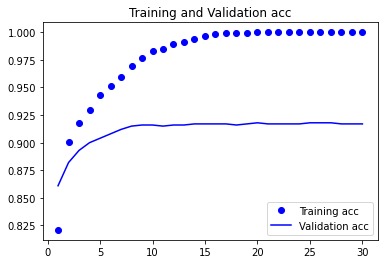

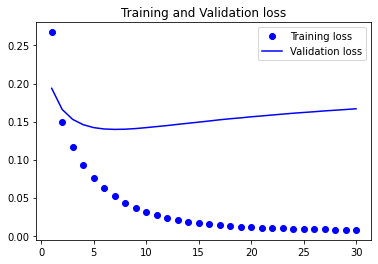

In [24]:

plt.plot(epoches, train_acc, 'bo', label="Training acc")
plt.plot(epoches, val_acces, 'b', label='Validation acc')
plt.title("Training and Validation acc")
plt.legend()
plt.figure()
plt.plot(epoches, train_loss, 'bo', label="Training loss")
plt.plot(epoches, val_losses, 'b', label='Validation loss')
plt.title("Training and Validation loss")
plt.legend()
plt.show()